In [1]:
! pip install -Uqqq ftfy regex tqdm datasets transformers
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hic48aos
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hic48aos
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


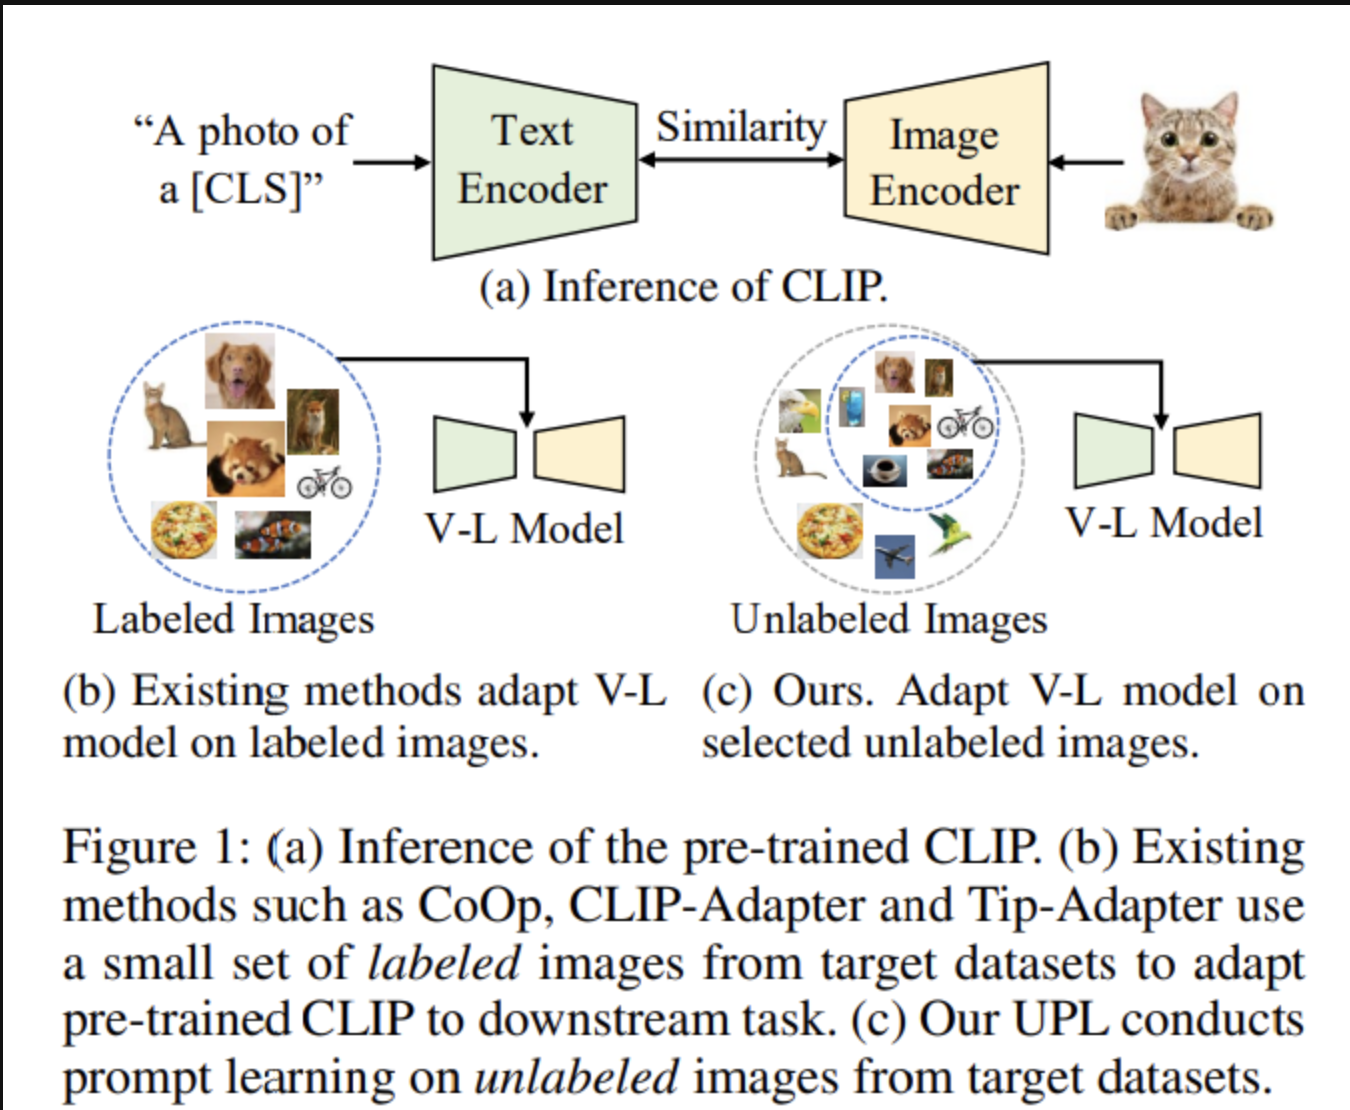

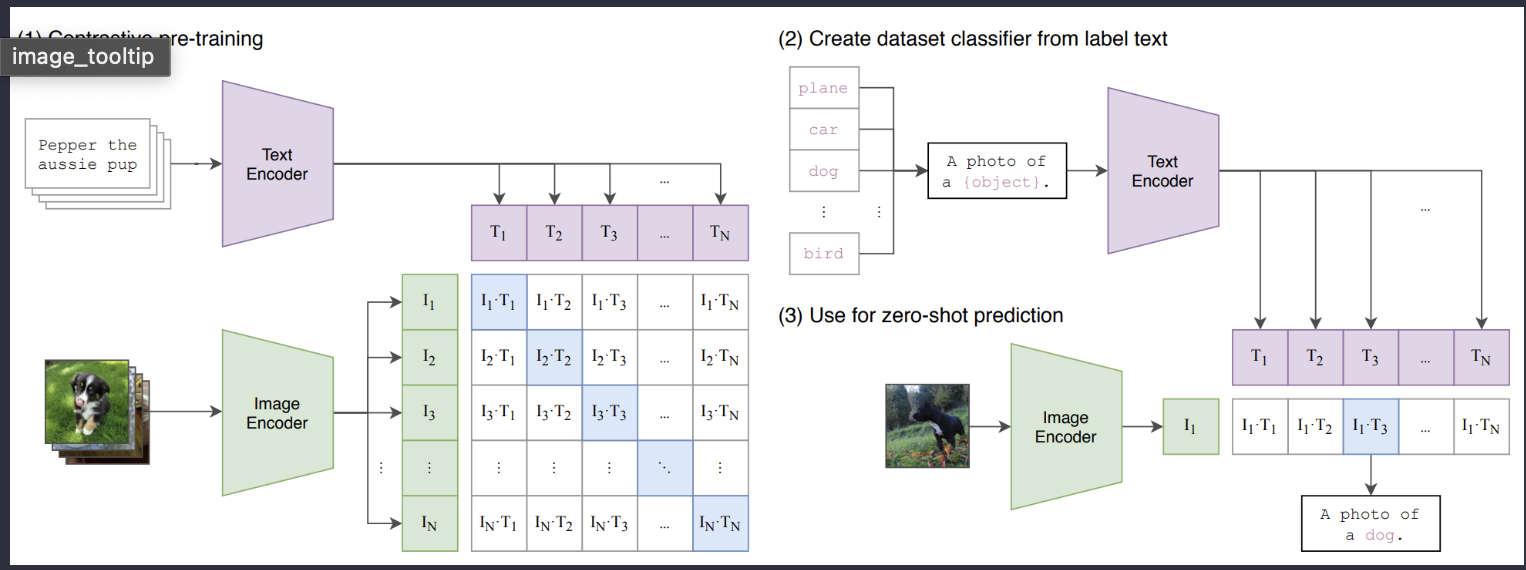

In [2]:
import transformers
import datasets
from datasets import load_dataset
import clip

import numpy as np
import pandas as pd

!pip install -q --upgrade torch_snippets
from torch_snippets import *
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.utils import make_grid
from torch_snippets import *
from PIL import Image
import torchvision
from torchvision import transforms
import torchvision.utils as vutils

from PIL import Image
import requests

from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

In [3]:
imagenette = load_dataset(
    'frgfm/imagenette',
    '320px',
    split='validation',
    revision="4d512db"
)
# show dataset info
imagenette

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

In [6]:
# check labels in the dataset
set(imagenette['label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [10]:
# labels names
labels = imagenette.info.features['label'].names
labels

['tench',
 'English springer',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [11]:
# generate sentences
clip_labels = [f"a photo of a {label}" for label in labels]
clip_labels

['a photo of a tench',
 'a photo of a English springer',
 'a photo of a cassette player',
 'a photo of a chain saw',
 'a photo of a church',
 'a photo of a French horn',
 'a photo of a garbage truck',
 'a photo of a gas pump',
 'a photo of a golf ball',
 'a photo of a parachute']

# Loading the model
Download and instantiate a CLIP model using the clip module that we just installed.

In [10]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [11]:
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)


In [12]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [13]:
from tqdm.auto import tqdm

preds = []
batch_size = 32

for i in tqdm(range(0, len(imagenette), batch_size)):
    i_end = min(i + batch_size, len(imagenette))
    images = processor(
        text=None,
        images=imagenette[i:i_end]['image'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

  0%|          | 0/123 [00:00<?, ?it/s]

In [14]:
true_preds = []
for i, label in enumerate(imagenette['label']):
    if label == preds[i]:
        true_preds.append(1)
    else:
        true_preds.append(0)

sum(true_preds) / len(true_preds)

0.965859872611465

In [15]:
#EXAMPLE
#https://jovian.com/nkafr/clip

In [10]:
urls=['https://images.unsplash.com/photo-1662955676669-c5d141718bfd?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=687&q=80',
    'https://images.unsplash.com/photo-1552053831-71594a27632d?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=662&q=80',
    'https://images.unsplash.com/photo-1530281700549-e82e7bf110d6?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=688&q=80']

images=[Image.open(requests.get(i, stream=True).raw)  for i in urls]

In [13]:
# text_prompts=["a girl wearing a beanie", "a boy wearing a beanie", "a dog", "a dog at the beach"]
# inputs = inputs = processor(text=text_prompts, images=images, return_tensors="pt", padding=True)

# outputs = model(**inputs)
# logits_per_image = outputs.logits_per_image
# probs = logits_per_image.softmax(dim=1)

In [14]:
# pd.DataFrame(probs.detach().numpy()*100, columns=text_prompts, index=list(['image1','image2', 'image3'])).style.background_gradient(axis=None,low=0, high=0.91).format(precision=2)

#Resources:
- https://www.docomatic.ai/blog/openai/image-recognition-with-openai/
- https://fullstackdeeplearning.com/course/2022/lecture-7-foundation-models/
